In [1]:
import tensorflow as tf
import numpy as np
import torch
import torchvision as tv
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-11 18:56:43.902962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# random data between (-10, 10) and determine groundtruth
simIn = 20 * torch.rand((1000, 1)) - 10
groundTruth = np.cos(simIn)

In [3]:
# number of parameters in a NN
def calculate_parameters(inputModel):
    val = sum(params.numel() for params in inputModel.parameters() if params.requires_grad)
    return val

In [4]:
# Set up NN for cos(x) training - 2 Hidden Layers, 32 parameters - Shallow Network
class NNOptimize(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, val):
        val = F.relu(self.fc1(val))
        val = F.relu(self.fc2(val))
        val = self.fc3(val)
        return val

In [5]:
# necessary auxilaries for neural net training
optimum_network = NNOptimize()
costFun = nn.MSELoss()
opt = optim.Adam(optimum_network.parameters(), lr=0.001)

In [6]:
Iteration_training = 8
EPOCHS = 45 # Must be divisible by 3 for how number_epoch is used in training
number_epoch = round(EPOCHS / 3)
l1Conn = 3
l2Conn = 15
l3Conn = 5
totalConn = l1Conn + l2Conn + l3Conn

# Number of training iterations for visualization
costList = []
c = 0
l2weight = torch.zeros((Iteration_training * number_epoch, l2Conn))
allModelTensor = torch.zeros((Iteration_training * number_epoch, totalConn))
cTensor = torch.zeros((Iteration_training * number_epoch, 1))
for train_idx in range(Iteration_training): 
    
    # Training of individual series, reset model on every series
    optimum_network = NNOptimize()
    costFun = nn.MSELoss()
    opt = optim.Adam(optimum_network.parameters(), lr=0.001)
    for epochIndex in range(EPOCHS):
        optimum_network.zero_grad()
        output = optimum_network(simIn)
        cost = costFun(output, groundTruth)
        cost.backward()
        opt.step()

        # Every 3 epochs, collect weights and cost
        if epochIndex % 3 == 0:
            # Gather weights of the model
            layer1Weights = torch.reshape(torch.flatten(optimum_network.fc1.weight), (1, l1Conn))
            layer2Weights = torch.reshape(torch.flatten(optimum_network.fc2.weight), (1, l2Conn))
            layer3Weights = torch.reshape(torch.flatten(optimum_network.fc3.weight), (1, l3Conn))
            # Combine weights for whole model
            temp = torch.cat((layer2Weights, layer1Weights), dim=1)
            wholeModelWeights = torch.cat((temp, layer3Weights), dim=1)
            # Save weights and cost for later
            allModelTensor[c] = wholeModelWeights
            l2weight[c] = layer2Weights
            cTensor[c] = cost
            c += 1

In [7]:
# Implementation of PCA for dimention reduction of weights
def pca_impl(inputArray, dimToReturn):
    m, n = inputArray.shape
    
    # Calculate means and Normalize by subtracting mean from each column
    m_in = np.array([np.mean(inputArray[:, index]) for index in range(n)])
    in_normal = inputArray - m_in
    
    # Calculate eigenvalues and eigenvectors
    # X'X 
    mtr = np.dot(np.transpose(in_normal),in_normal)
    eigenvalues, eigenvectors = np.linalg.eig(mtr)
    pairs = [(np.abs(eigenvalues[index]), eigenvectors[:, index]) for index in range(n)]

    # Sort pairs and return dimensions requested
    pairs.sort(key=lambda x: x[0], reverse=True)
    featData = np.array([value[1] for value in pairs[:dimToReturn]])
    reducedData = np.dot(in_normal, np.transpose(featData))
    return reducedData

In [8]:
# Reduce dimensions using PCA
l2Reduce = l2weight.detach().cpu().numpy()
print(l2Reduce.shape)
allModelReduce = allModelTensor.detach().cpu().numpy()
costVector = cTensor.detach().cpu().numpy()
l2Reduce = pca_impl(l2Reduce, 2)
allModelReduce = pca_impl(allModelReduce, 2)

(120, 15)


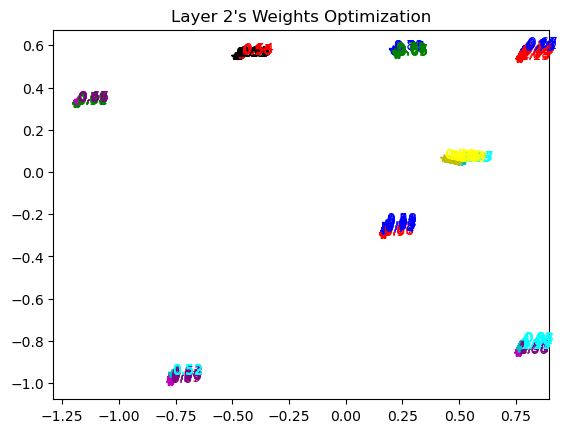

In [9]:
# Plot optimization of Layer 2 of NN
color_List = ['r*', 'b*', 'g*', 'm*', 'c*', 'y*', 'k*']
colorNameList = ["red", "blue", "green", "purple", "cyan", "yellow", 'black']
c = 0
colorCounter = 0
for pair in l2Reduce:
    if (c % 10) == 0 and c != 0:
        # Change Color
        if colorCounter >= len(color_List) - 1:
            colorCounter = 0
        else:
            colorCounter += 1
    plt.plot(pair[0], pair[1], color_List[colorCounter])
    plt.annotate(str(round(costVector[c][0], 2)), (pair[0], pair[1]), color=colorNameList[colorCounter])
    c += 1
plt.title("Layer 2's Weights Optimization") 
plt.show()

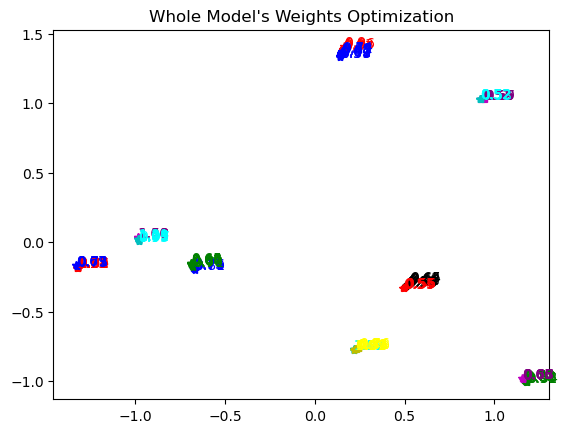

In [10]:
# Plot optimization of Whole Model of NN
c = 0
colorCounter = 0
for pair in allModelReduce:
    if (c % 10) == 0 and c != 0:
        if colorCounter >= len(color_List) - 1:
            colorCounter = 0
        else:
            colorCounter += 1
    plt.plot(pair[0], pair[1], color_List[colorCounter])
    plt.annotate(str(round(costVector[c][0], 2)), (pair[0], pair[1]), color=colorNameList[colorCounter])
    c += 1
plt.title("Whole Model's Weights Optimization")
plt.show()